# Human Feedback loop

In [1]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langgraph.types import Command,Interrupt
from langchain_tavily import TavilySearch
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image,display
from langchain_core.tools import tool


In [5]:
class State(TypedDict):
    messages:Annotated[list,add_messages]

In [6]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
from langchain_groq import ChatGroq
from langchain.chat_models import init_chat_model

llm=ChatGroq(model="openai/gpt-oss-20b")


In [3]:
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x10874bb60>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x108938830>, model_name='openai/gpt-oss-20b', model_kwargs={}, groq_api_key=SecretStr('**********'))

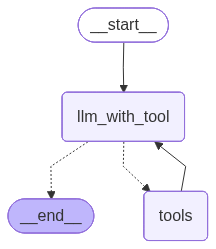

In [7]:
graph_builder=StateGraph(State)
memory=MemorySaver()


def human_feedback(query:str)->str:
    """ Requested assitance from a human """
    human_response=Interrupt({"query":query})
    return human_response["data"]

tool1=TavilySearch(max_results=2)
tools=[tool1,human_feedback]
llm_with_tools=llm.bind_tools(tools)

def chat_bot(state: State):
    message=llm_with_tools.invoke(state["messages"])
    #because we will be interupting during the tool execution
    # we disable parallel tool calling to avoid repeating any 
    # tool invocations when we resume 
    return {"messages":[message]}

graph_builder.add_node("llm_with_tool",chat_bot)
graph_builder.add_node("tools",ToolNode(tools=tools))

graph_builder.add_conditional_edges("llm_with_tool",tools_condition)

graph_builder.add_edge("tools","llm_with_tool")
graph_builder.add_edge(START,"llm_with_tool")
graph=graph_builder.compile(checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png()))





In [15]:
user_input="I need some expert assistance and guidance to build my ai agent project "
config={"configurable":{"thread_id":"1"}}

response=graph.stream({"messages":user_input},
                      stream_mode="values",
                      config=config)
for event in response:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

I need some expert assistance and guidance to build my ai agent project 
================================== Ai Message ==================================

Absolutely—let’s get started!  
To give you the most useful, tailored advice, I’d love to understand a few key details about your AI‑agent project. Once we have that picture, I can outline a practical roadmap, recommend tools & frameworks, sketch out architecture, and point you to resources, tutorials, and best practices.

### Quick Clarifying Questions

| # | Question | Why it matters |
|---|----------|----------------|
| 1 | **What’s the core purpose of the agent?** (e.g., personal productivity assistant, customer‑service chatbot, data‑analysis bot, autonomous decision‑maker, etc.) | Determines the functional scope and required skill sets. |
| 2 | **What data or knowledge base will it rely on?** (e.g., internal documents, public APIs, web scraping, pr

In [16]:
human_resposne=("hi , iam an ai agentic engineer for your assistance how may i help you")
human_command=Command(resume={"data":human_resposne}
                      )
events=graph.stream(human_command,config=config,stream_mode="values")

for event in events:
    event["messages"][-1].pretty_print()

================================== Ai Message ==================================

Absolutely—let’s get started!  
To give you the most useful, tailored advice, I’d love to understand a few key details about your AI‑agent project. Once we have that picture, I can outline a practical roadmap, recommend tools & frameworks, sketch out architecture, and point you to resources, tutorials, and best practices.

### Quick Clarifying Questions

| # | Question | Why it matters |
|---|----------|----------------|
| 1 | **What’s the core purpose of the agent?** (e.g., personal productivity assistant, customer‑service chatbot, data‑analysis bot, autonomous decision‑maker, etc.) | Determines the functional scope and required skill sets. |
| 2 | **What data or knowledge base will it rely on?** (e.g., internal documents, public APIs, web scraping, proprietary datasets) | Influences storage, retrieval, and privacy considerations. |
| 3 | **What level of autonomy / decision‑making do you want?** (simple 